In [1]:
import os
from PIL import Image
import numpy as np

image_dir = "/kaggle/input/dataset-deepfake/preprocessed"

images = []
labels = []

for filename in os.listdir(image_dir):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.webp') or filename.endswith('.jpeg'):
       
        image_path = os.path.join(image_dir, filename)
        
        
        image = Image.open(image_path)
        
        image = image.resize((224, 224))
       
        image_array = np.array(image) / 255.0
    
        images.append(image_array)
        
      
        if 'real' in filename.lower():
            labels.append(0)  
        elif 'fake' in filename.lower():
            labels.append(1)  

images = np.array(images)
labels = np.array(labels)



In [2]:
!pip install tensorflow vit-keras mtcnn albumentations tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profil

In [3]:
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import EfficientNetB7
from vit_keras import vit
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf

def resize_images(images, size=(384, 384)):
    resized_images = np.array([tf.image.resize(image, size).numpy() for image in images])
    return resized_images

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

train_images = resize_images(train_images)
test_images = resize_images(test_images)

efficientnet_b7 = EfficientNetB7(include_top=False, input_shape=(384, 384, 3), weights='imagenet')
efficientnet_b7.trainable = False  

vit_model = vit.vit_l32(
    image_size=384,
    activation='sigmoid',
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

# Combine both models
input_shape = (384, 384, 3)
inputs = Input(shape=input_shape)
eff_output = efficientnet_b7(inputs)
vit_output = vit_model(inputs)

flatten_eff = Flatten()(eff_output)
flatten_vit = Flatten()(vit_output)
combined_output = Concatenate()([flatten_eff, flatten_vit])

dense = Dense(128, activation='relu')(combined_output)
dropout = Dropout(0.5)(dense)
outputs = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=inputs, outputs=outputs)

optimizer = SGD(lr=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(train_images, train_labels, epochs=40, batch_size=12, validation_split=0.2)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")

model.save("combined_deepfake_detector.h5")

test_preds = model.predict(test_images)
test_preds = (test_preds > 0.5).astype(int)
f1 = f1_score(test_labels, test_preds)
print(f"F1 score: {f1}")


2024-06-21 06:34:08.499479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 06:34:08.499581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 06:34:08.613894: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our Tens

1226658854/1226658854 [==============================] - 18s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 384, 384, 3)]        0         []                            
                                                                                                  
 efficientnetb7 (Functional  (None, 12, 12, 2560)         6409768   ['input_3[0][0]']             
 )                                                        7                                       
                                                                                                  
 vit-l32 (Functional)        (None, 1024)                 3056076   ['input_3[0][0]']             
                                                          80                                      
                        

2024-06-21 06:36:11.836047: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1718951781.801418     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 [==============================] - 153s 1s/step - loss: 18.1965 - accuracy: 0.8172 - val_loss: 0.6392 - val_accuracy: 0.8625
Epoch 2/40
54/54 [==============================] - 55s 1s/step - loss: 0.6216 - accuracy: 0.8469 - val_loss: 0.5932 - val_accuracy: 0.8625
Epoch 3/40
54/54 [==============================] - 55s 1s/step - loss: 0.5804 - accuracy: 0.8469 - val_loss: 0.5564 - val_accuracy: 0.8625
Epoch 4/40
54/54 [==============================] - 55s 1s/step - loss: 0.5451 - accuracy: 0.8469 - val_loss: 0.5295 - val_accuracy: 0.8625
Epoch 5/40
54/54 [==============================] - 55s 1s/step - loss: 0.5275 - accuracy: 0.8469 - val_loss: 0.5067 - val_accuracy: 0.8625
Epoch 6/40
54/54 [==============================] - 55s 1s/step - loss: 0.5086 - accuracy: 0.8469 - val_loss: 0.4882 - val_accuracy: 0.8625
Epoch 7/40
54/54 [==============================] - 55s 1s/step - loss: 0.5048 - accuracy: 0.8469 - val_loss: 0.4738 - val_accuracy: 0.8625
Epoch 8/40
54/54 [===========

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 18s 1s/step
F1 score: 0.921832884097035


7/7 [==============================] - 7s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.85      1.00      0.92       171

    accuracy                           0.85       200
   macro avg       0.43      0.50      0.46       200
weighted avg       0.73      0.85      0.79       200

Sensitivity: 1.0
Specificity: 0.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


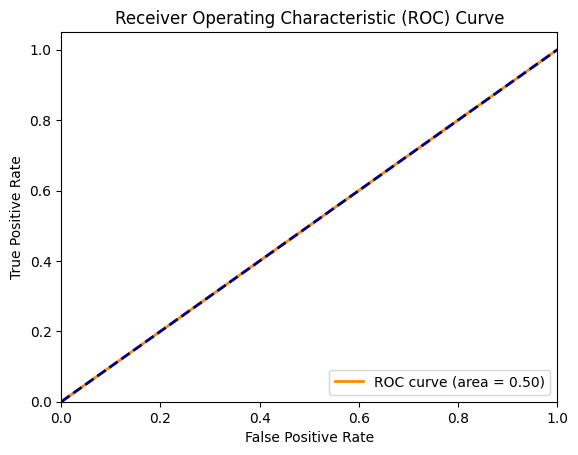

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

predictions = model.predict(test_images)
predicted_labels = np.round(predictions).astype(int).flatten() 

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

conf_matrix = confusion_matrix(test_labels, predicted_labels)
tn, fp, fn, tp = conf_matrix.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

# Step 4: Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
